In [64]:
# -*- coding: utf-8 -*-
"""
Created on Tue Dec 24 02:24:12 2019

@author: Admin
"""

import pandas as pd
import numpy as np

from scipy.signal import savgol_filter, argrelextrema
import openpyxl

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import datasets

import pickle
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
# from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix

import warnings,os
warnings.simplefilter('ignore')

import matplotlib as mpl
import matplotlib.dates as mdates
import datetime as dt
import csv

import seaborn as sns
import matplotlib.pyplot as plt

from pylab import rcParams

path="C:\\Users\\Admin\\Documents\\"

In [65]:
# def CreateData(dataFrame):
# #    dataset =np.array( dataFrame.iloc[:, 0:964])
#     dataset =np.array( dataFrame.iloc[:, list(dataFrame.columns).index(284.893653497196):list(dataFrame.columns).index(2162.7174062946)])    
#     target = dataFrame.loc[:,['label']]
#     target = np.array(target.replace(to_replace=['О', 'К'], value=[1, 0]))
#     target =target.astype('int32')   
#     target.transpose()
#     return dataset,target

def CreateData(dataFrame):
    dataset =np.array( dataFrame.iloc[:, 0:1044])
    target = dataFrame.loc[:,['label']]
    target = np.array(target.replace(to_replace=['О', 'К'], value=[1, 0]))
    target =target.astype('int32')   
    target.transpose()
    x=np.where(np.isnan(dataset))[0]
    x=np.unique(x)
    i=0   
    for item in x:
        dataset=np.delete(dataset, item-i, axis=0)
        target=np.delete(target, item-i)
        i+=1
    return dataset,target

In [66]:
#сохранение
def saveModel(score,path,nameModel):
    save=False
    dateFile = os.listdir(path)
    name=path+ str(score)+'_'+nameModel+'.pkl'
    for item in dateFile:
        temp=item.split('_')
        if len(temp)==2:
            if (temp[1].find(nameModel)!=-1):
                if (float(temp[0])<score):
                    print("Модель",nameModel,"сохранена\n")
                    save=True
                break
    else:
        save=True
    return save,name

# StandardScaler
Идея StandardScaler заключается в том, что он преобразует данные так, что бы их распределение будет иметь среднее значение 0 и стандартное отклонение 1. Учитывая распределение данных, каждое значение в наборе данных будет вычтено из среднего значения выборки, а затем разделено на стандартное отклонение всего набора данных.

In [67]:
# path="C:\\Users\\admin\\Downloads\\Telegram Desktop\\new_sav_filter_data_scaled.xlsx"
path="C:\\Users\\Admin\\Documents\\PythonRamanCopy\\raman2.xlsx"

dataFrame = pd.read_excel(path)
clear_data, target=CreateData(dataFrame)

train_dataset ,  test_dataset ,  train_target ,  test_target=train_test_split(clear_data, target, test_size=0.10,stratify=target)
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
normalized_train_dataset = scaler.fit_transform(train_dataset)
normalized_test_dataset = scaler.fit_transform(test_dataset)
spec=[]
ch=[]

# Support Vector Classification

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.0min finished


0.29478458049886624 0.55 

[[33 12]
 [18 36]]
Специфичность 0.7333333333333333
Чувствительность 0.6666666666666666
--------------
f1ScoreWeighted= 0.6975267379679145
f1ScoreMacro= 0.6966911764705883
f1ScoreBinary= 0.7058823529411765
Точноть 0.696969696969697


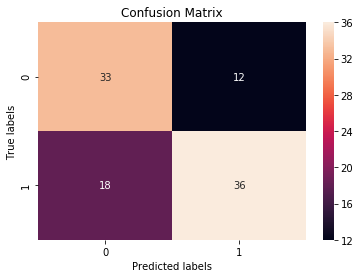

In [68]:
from sklearn.svm import NuSVC

nuSVC=NuSVC()

#GridSearchCV
#----------------------------------------------------------------------
tuned_parameters = {'nu':np.arange(.05,0.95,0.05)}
nu_svc = GridSearchCV(nuSVC,param_grid=tuned_parameters,cv=5, verbose=True)
nu_svc.fit(normalized_train_dataset, train_target)
best_parameter_nu = nu_svc.best_estimator_.nu
best_cv_err = 1 - nu_svc.best_score_
print (best_cv_err, best_parameter_nu,"\n")

#Обучение модели с оптимальными параметрами
NuSVC2 = NuSVC(gamma='scale',nu=best_parameter_nu,probability=True)
NuSVC2.fit(normalized_train_dataset, train_target)

#предсказание
expected = test_target
predicted = NuSVC2.predict(normalized_test_dataset)
predicted_NuSVC2=predicted
expected_NuSVC2_traine = train_target
predicted_NuSVC2_train = NuSVC2.predict(normalized_train_dataset)

#Отрисовка confusion_matrix
cm = metrics.confusion_matrix(expected, predicted)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')
    

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
# ax.xaxis.set_ticklabels(['К', 'О']); 

f1ScoreWeighted=f1_score(test_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)

f1ScoreBinary=f1_score(test_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

buff_score=NuSVC2.score(normalized_test_dataset, test_target)
print('Точноть',buff_score)
Score=[buff_score]
NameModel=["nuSVC"]
# save,name=saveModel(Score[len(Score)-1],path,NameModel[len(NameModel)-1])

# if save==True:
#     with open(name, 'wb') as fid:
#         pickle.dump(NuSVC2, fid)

# Обучающая выборка

[[379  21]
 [193 289]]
Специфичность 0.9475
Чувствительность 0.5995850622406639
--------------
f1ScoreWeighted= 0.7524906832666974
f1ScoreMacro= 0.754816685372241
f1ScoreBinary= 0.7297979797979799
Точноть 0.7573696145124716


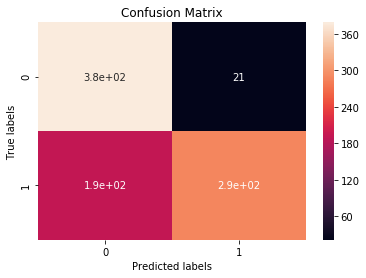

In [69]:
#предсказание
expected = train_target
predicted = NuSVC2.predict(normalized_train_dataset)

#Отрисовка confusion_matrix
cm = metrics.confusion_matrix(expected, predicted)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')
    
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

f1ScoreWeighted=f1_score(train_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(train_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)

f1ScoreBinary=f1_score(train_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

buff_score=NuSVC2.score(normalized_train_dataset, train_target)
print('Точноть',buff_score)

# Дерево принятия решений

Дерево принятия решений

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.34467120181405897 10 17 

[[20 25]
 [12 42]]
Специфичность 0.4444444444444444
Чувствительность 0.7777777777777778
--------------
f1ScoreWeighted= 0.6147901685091769
f1ScoreMacro= 0.6068476977567887
f1ScoreBinary= 0.694214876033058
Точноть 0.6262626262626263


[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed:    9.4s finished


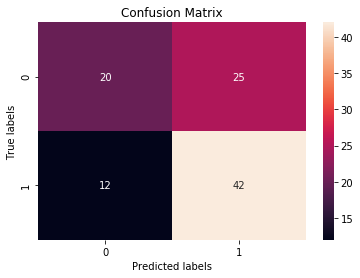

In [70]:
from sklearn.tree import DecisionTreeClassifier
#Cart
print("Дерево принятия решений\n")

#GridSearchCV
cartModel = DecisionTreeClassifier()
tuned_parameters = {'max_depth': np.arange(1,11),
                'max_features': np.arange(4,19)}
tree_grid = GridSearchCV(cartModel, tuned_parameters,cv=5, 
                         verbose=True)
tree_grid.fit(normalized_train_dataset, train_target)

best_parameter_max_depth = tree_grid.best_estimator_.max_depth
best_parameter_max_features = tree_grid.best_estimator_.max_features
best_cv_err = 1 - tree_grid.best_score_
print (best_cv_err, best_parameter_max_depth,best_parameter_max_features,"\n")

#Обучение модели с оптимальными параметрами
cartModel = DecisionTreeClassifier(max_depth=best_parameter_max_depth,
                                   max_features=best_parameter_max_features)
cartModel.fit(normalized_train_dataset, train_target)

#предсказание
expected = test_target
predicted = cartModel.predict(normalized_test_dataset)
predicted_cartModel=predicted
expected_cartModel_traine = train_target
predicted_cartModel_train = cartModel.predict(normalized_train_dataset)


#Отрисовка confusion_matrix
cm = metrics.confusion_matrix(expected, predicted)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
#--------------------------------------------------------------------

f1ScoreWeighted=f1_score(test_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)

f1ScoreBinary=f1_score(test_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

buff_score=cartModel.score(normalized_test_dataset, test_target)
print('Точноть',buff_score)
Score.append(buff_score)
NameModel.append("cartModel")
# save,name=saveModel(Score[len(Score)-1],path,NameModel[len(NameModel)-1])

# if save==True:
#     with open(name, 'wb') as fid:
#         pickle.dump(cartModel, fid)

# Обучающая выборка

[[322  78]
 [ 59 423]]
Специфичность 0.805
Чувствительность 0.8775933609958506
--------------
f1ScoreWeighted= 0.8442829420332281
f1ScoreMacro= 0.8426072945580634
f1ScoreBinary= 0.8606307222787386
Точноть 0.844671201814059


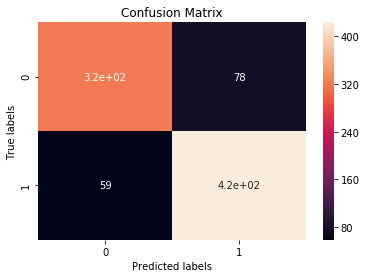

In [71]:
#предсказание
expected = train_target
predicted = cartModel.predict(normalized_train_dataset)

#Отрисовка confusion_matrix
cm = metrics.confusion_matrix(expected, predicted)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')
    
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

f1ScoreWeighted=f1_score(train_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(train_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)

f1ScoreBinary=f1_score(train_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

buff_score=cartModel.score(normalized_train_dataset, train_target)
print('Точноть',buff_score)

# Логическая регрессия

Логическая регрессия

0.21541950113378683 86 

[[35 10]
 [13 41]]
Специфичность 0.7777777777777778
Чувствительность 0.7592592592592593
--------------
f1ScoreWeighted= 0.7681050132663035
f1ScoreMacro= 0.7668202764976959
f1ScoreBinary= 0.780952380952381
Точноть 0.7676767676767676


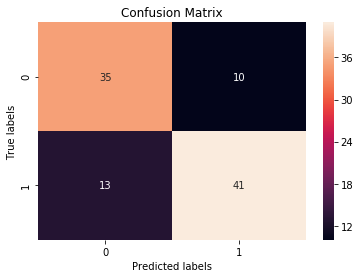

In [72]:
from sklearn.linear_model import LogisticRegression
#Логическая регрессия
print("Логическая регрессия\n")

#GridSearchCV
tuned_parameters = {'C': list(range(1,150))}
grid = GridSearchCV(LogisticRegression(solver='liblinear'), tuned_parameters, 
                   cv=5, scoring="accuracy")
grid.fit(normalized_train_dataset, train_target)

best_cv_err2 = 1 - grid.best_score_
best_parameter = grid.best_estimator_.C
print (best_cv_err2, best_parameter,"\n")

#Обучение модели с оптимальными параметрами
lgModel = LogisticRegression(C=best_parameter)
lgModel.fit(normalized_train_dataset, train_target)

expected = test_target
predicted = lgModel.predict(normalized_test_dataset)
predicted_lgModel=predicted
expected_lgModel_traine = train_target
predicted_lgModel_train = lgModel.predict(normalized_train_dataset)

#Отрисовка confusion_matrix
cm = metrics.confusion_matrix(expected, predicted)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')  

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
# ax.xaxis.set_ticklabels(['К', 'О']); 

f1ScoreWeighted=f1_score(test_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)

f1ScoreBinary=f1_score(test_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

buff_score=lgModel.score(normalized_test_dataset, test_target)
print('Точноть',buff_score)
Score.append(buff_score)
NameModel.append("lgModel")
# save,name=saveModel(Score[len(Score)-1],path,NameModel[len(NameModel)-1])
# if save==True:
#     with open(name, 'wb') as fid:
#         pickle.dump(lgModel, fid)

# Обучающая выборка

[[358  42]
 [ 99 383]]
Специфичность 0.895
Чувствительность 0.7946058091286307
--------------
f1ScoreWeighted= 0.8404291284157516
f1ScoreMacro= 0.8400075131963376
f1ScoreBinary= 0.8445424476295479
Точноть 0.8401360544217688


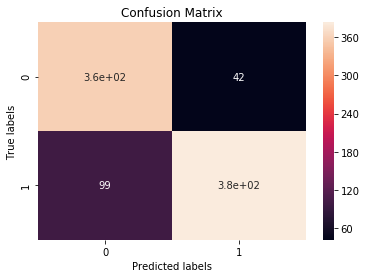

In [73]:
#предсказание
expected = train_target
predicted = lgModel.predict(normalized_train_dataset)

#Отрисовка confusion_matrix
cm = metrics.confusion_matrix(expected, predicted)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')
    
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

f1ScoreWeighted=f1_score(train_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(train_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)

f1ScoreBinary=f1_score(train_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

buff_score=lgModel.score(normalized_train_dataset, train_target)
print('Точноть',buff_score)

# Создание модели КNN

КNN

0.308390022675737 10 

[[34 11]
 [18 36]]
Специфичность 0.7555555555555555
Чувствительность 0.6666666666666666
--------------
f1ScoreWeighted= 0.7074893056315941
f1ScoreMacro= 0.7069511074818822
f1ScoreBinary= 0.7128712871287127
Точноть 0.7070707070707071


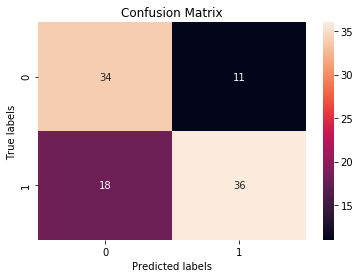

In [74]:
#Создание модели КNN
from sklearn.neighbors import KNeighborsClassifier
print("КNN\n")
#----------------------------------------------------------------------
#GridSearchCV
tuned_parameters= list(range(1,30))
knnModel = KNeighborsClassifier()
grid = GridSearchCV(knnModel, param_grid={'n_neighbors': tuned_parameters},cv=5)
grid.fit(normalized_train_dataset, train_target)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print (best_cv_err, best_n_neighbors,"\n")
#----------------------------------------------------------------------
#Обучение модели с оптимальными параметрами

knnModel = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knnModel.fit(normalized_train_dataset, train_target)

expected = test_target
predicted = knnModel.predict(normalized_test_dataset)
predicted_knnModel=predicted

expected_knnModel_traine = train_target
predicted_knnModel_train = knnModel.predict(normalized_train_dataset)
#---------------------------------------------------------------------
#Отрисовка confusion_matrix

cm = metrics.confusion_matrix(expected, predicted_knnModel)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')   

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
#--------------------------------------------------------------------
#Результаты
f1ScoreWeighted=f1_score(test_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)
      
f1ScoreBinary=f1_score(test_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

buff_score=knnModel.score(normalized_test_dataset, test_target)
Score.append(buff_score)
print('Точноть',buff_score)
NameModel.append("knnModel")
# save,name=saveModel(Score[len(Score)-1],path,NameModel[len(NameModel)-1])
# if save==True:
#     with open(name, 'wb') as fid:
#         pickle.dump(knnModel, fid)

# Обучающая выборка

[[330  70]
 [167 315]]
Специфичность 0.825
Чувствительность 0.6535269709543569
--------------
f1ScoreWeighted= 0.7307897911607426
f1ScoreMacro= 0.7312147758965872
f1ScoreBinary= 0.726643598615917
Точноть 0.7312925170068028


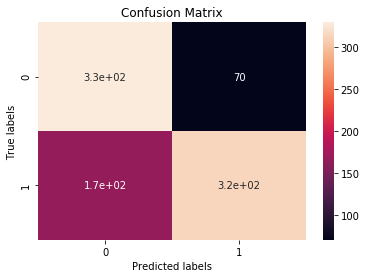

In [75]:
#предсказание
expected = train_target
predicted = knnModel.predict(normalized_train_dataset)

#Отрисовка confusion_matrix
cm = metrics.confusion_matrix(expected, predicted)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')
    
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

f1ScoreWeighted=f1_score(train_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(train_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)

f1ScoreBinary=f1_score(train_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

buff_score=knnModel.score(normalized_train_dataset, train_target)
print('Точноть',buff_score)

# Случайный лес

err= 0.31746031746031744  best_n_estimators= 45  max_features= 3 

[[23 22]
 [11 43]]
Специфичность 0.5111111111111111
Чувствительность 0.7962962962962963
--------------
f1ScoreWeighted= 0.6588660780768004
f1ScoreMacro= 0.6524837783214552
f1ScoreBinary= 0.7226890756302522
Точноть 0.6666666666666666


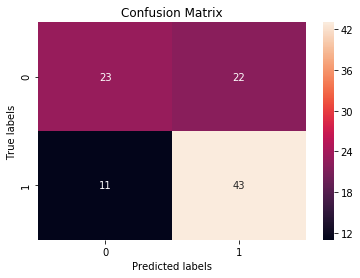

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble
from sklearn.metrics import roc_auc_score         
#----------------------------------------------------------------------
#GridSearchCV
RDF_model = ensemble.RandomForestClassifier()
tuned_parameters={'n_estimators': np.arange(10,100),'max_features':np.arange(1,5)}
grid = GridSearchCV(RDF_model, param_grid=tuned_parameters,cv=5)
grid.fit(normalized_train_dataset, train_target)

best_cv_err = 1 - grid.best_score_
best_n_estimators = grid.best_estimator_.n_estimators
best_max_features = grid.best_estimator_.max_features
print ('err=',best_cv_err, " best_n_estimators=",best_n_estimators, " max_features=",best_max_features,"\n")
#----------------------------------------------------------------------
#Обучение модели с оптимальными параметрами

RDF_grid_model = RandomForestClassifier(n_estimators=best_n_estimators,max_features=best_max_features,oob_score=True,)
RDF_grid_model.fit(normalized_train_dataset, train_target)

expected = test_target
predicted_RDF = RDF_grid_model.predict(normalized_test_dataset)

expected_RDF_grid_traine = train_target
predicted_RDF_grid_train = RDF_grid_model.predict(normalized_train_dataset)
#---------------------------------------------------------------------
#Отрисовка confusion_matrix

cm = metrics.confusion_matrix(test_target, predicted_RDF)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')  

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
#--------------------------------------------------------------------
#Результаты
f1ScoreWeighted=f1_score(test_target, predicted_RDF, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted_RDF, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)
      
f1ScoreBinary=f1_score(test_target, predicted_RDF, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

buff_score=RDF_grid_model.score(normalized_test_dataset, test_target)
Score.append(buff_score)
print('Точноть',buff_score)
NameModel.append("RDF")
# save,name=saveModel(Score[len(Score)-1],path,NameModel[len(NameModel)-1])
# if save==True:
#     with open(name, 'wb') as fid:
#         pickle.dump(RDF_grid_model, fid)

# Обучающая выборка

[[330  70]
 [167 315]]
Специфичность 0.825
Чувствительность 0.6535269709543569
--------------
f1ScoreWeighted= 0.7307897911607426
f1ScoreMacro= 0.7312147758965872
f1ScoreBinary= 0.726643598615917
Точноть 0.7312925170068028


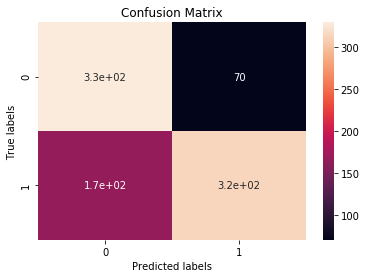

In [77]:
#предсказание
expected = train_target
predicted = knnModel.predict(normalized_train_dataset)

#Отрисовка confusion_matrix
cm = metrics.confusion_matrix(expected, predicted)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')
    
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

f1ScoreWeighted=f1_score(train_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(train_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)

f1ScoreBinary=f1_score(train_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

buff_score=knnModel.score(normalized_train_dataset, train_target)
print('Точноть',buff_score)

# Наивный Байес

Наивный Байес

[[43  2]
 [45  9]]
Специфичность 0.9555555555555556
Чувствительность 0.16666666666666666
--------------
f1ScoreWeighted= 0.44496556075503446
f1ScoreMacro= 0.4617698091382302
f1ScoreBinary= 0.2769230769230769
Точноть 0.5252525252525253


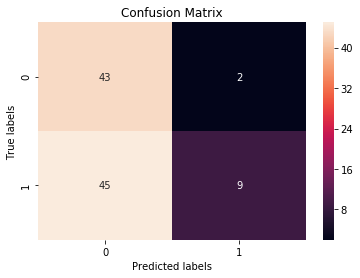

In [78]:
#Использование модели Наивный Байес
print("Наивный Байес\n")
from sklearn.naive_bayes import GaussianNB
#----------------------------------------------------------------------

nbModel = GaussianNB()
nbModel.fit(normalized_train_dataset, train_target)

expected = test_target
predicted = nbModel.predict(normalized_test_dataset)

#---------------------------------------------------------------------
#Отрисовка confusion_matrix

cm = metrics.confusion_matrix(expected, predicted)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------') 

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
#--------------------------------------------------------------------
#Результы
f1ScoreWeighted=f1_score(test_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)

f1ScoreBinary=f1_score(test_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

buff_score=nbModel.score(normalized_test_dataset, test_target)
Score.append(buff_score)
print('Точноть',buff_score)
NameModel.append("nbModel")
# save,name=saveModel(Score[len(Score)-1],path,NameModel[len(NameModel)-1])
# if save==True:
#     with open(name, 'wb') as fid:
#         pickle.dump(nbModel, fid)

# Обучающая выборка

[[381  19]
 [395  87]]
Специфичность 0.9525
Чувствительность 0.18049792531120332
--------------
f1ScoreWeighted= 0.45557406636123843
f1ScoreMacro= 0.4719387755102041
f1ScoreBinary= 0.29591836734693877
Точноть 0.5306122448979592


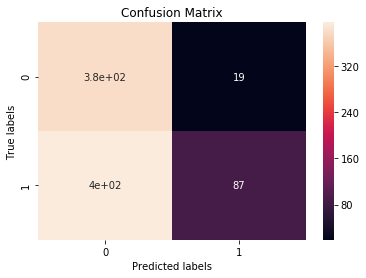

In [79]:
#предсказание
expected = train_target
predicted = nbModel.predict(normalized_train_dataset)

#Отрисовка confusion_matrix
cm = metrics.confusion_matrix(expected, predicted)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')
    
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

f1ScoreWeighted=f1_score(train_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(train_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)

f1ScoreBinary=f1_score(train_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

buff_score=nbModel.score(normalized_train_dataset, train_target)
print('Точноть',buff_score)

# Взвешенное голосование
RDF NuSVC2 knn lg cart nbModel

0.8038548752834467
0.8922902494331065
0.8560090702947846 

0.7272727272727273
0.7070707070707071
0.696969696969697 

[[39  6]
 [24 30]]
Специфичность 0.8666666666666667
Чувствительность 0.5555555555555556
--------------
f1ScoreWeighted= 0.6919191919191919
f1ScoreMacro= 0.6944444444444444
f1ScoreBinary= 0.6666666666666667
Точноть 0.696969696969697


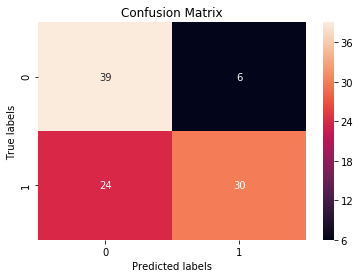

In [80]:
eclf1 = VotingClassifier(estimators=[('RDF',RDF_grid_model),('NuSVC2', NuSVC2), ('knn', knnModel), 
                                     ('lg', lgModel),('cart', cartModel),('nbModel',nbModel)], 
                                     voting='hard')
eclf1 = eclf1.fit(normalized_train_dataset, train_target)

eclf2 = VotingClassifier(estimators=[('RDF',RDF_grid_model),('NuSVC2', NuSVC2), ('knn', knnModel),
                                     ('lg', lgModel),('cart', cartModel),('nbModel',nbModel)],
                                     voting='soft')
eclf2 = eclf2.fit(normalized_train_dataset, train_target)

eclf3 = VotingClassifier(estimators=[('RDF',RDF_grid_model),('NuSVC2', NuSVC2), ('knn', knnModel), 
                                     ('lg', lgModel),('cart', cartModel),('nbModel',nbModel)],
                                    voting='soft', flatten_transform=True)
eclf3 = eclf3.fit(normalized_train_dataset, train_target)

print(eclf1.score( normalized_train_dataset, train_target))
print(eclf2.score( normalized_train_dataset, train_target))
print(eclf3.score( normalized_train_dataset, train_target),'\n')

print(eclf1.score( normalized_test_dataset, test_target))
print(eclf2.score( normalized_test_dataset, test_target))
print(eclf3.score( normalized_test_dataset, test_target),'\n')

# Score.append(max(eclf1.score( normalized_test_dataset, test_target),
#                            eclf2.score( normalized_test_dataset, test_target),
#                            eclf3.score( normalized_test_dataset, test_target)))
expected = test_target
predicted_VotingClassifier = eclf3.predict(normalized_test_dataset)

#---------------------------------------------------------------------
#Отрисовка confusion_matrix

cm = metrics.confusion_matrix(expected, predicted_VotingClassifier)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')  

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
# ax.xaxis.set_ticklabels(['К', 'О']); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
#--------------------------------------------------------------------
#Результаты
f1ScoreWeighted=f1_score(test_target, predicted_VotingClassifier, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted_VotingClassifier, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)
      
f1ScoreBinary=f1_score(test_target, predicted_VotingClassifier, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

buff_score=eclf3.score(normalized_test_dataset, test_target)
Score.append(buff_score)
print('Точноть',buff_score)
NameModel.append("VotingClassifier1")

# Обучающая выборка

[[395   5]
 [122 360]]
Специфичность 0.9875
Чувствительность 0.7468879668049793
--------------
f1ScoreWeighted= 0.8552499050877445
f1ScoreMacro= 0.8557819695918238
f1ScoreBinary= 0.8500590318772137
Точноть 0.8560090702947846


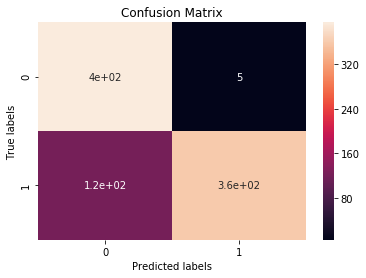

In [81]:
#предсказание
expected = train_target
predicted = eclf3.predict(normalized_train_dataset)

#Отрисовка confusion_matrix
cm = metrics.confusion_matrix(expected, predicted)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')
    
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

f1ScoreWeighted=f1_score(train_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(train_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)

f1ScoreBinary=f1_score(train_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

buff_score=eclf3.score(normalized_train_dataset, train_target)
print('Точноть',buff_score)

# Взвешенное голосование

RDF NuSVC2 knn lg cart


0.9047619047619048
0.971655328798186
0.9705215419501134 

0.7373737373737373
0.7272727272727273
0.7575757575757576 

[[39  6]
 [24 30]]
Специфичность 0.8666666666666667
Чувствительность 0.5555555555555556
--------------
f1ScoreWeighted= 0.7570247933884297
f1ScoreMacro= 0.7545454545454546
f1ScoreBinary= 0.7818181818181819
Точноть 0.7575757575757576


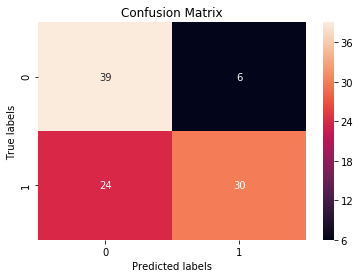

In [82]:
eclf1 = VotingClassifier(estimators=[('RDF',RDF_grid_model),('NuSVC2', NuSVC2), ('knn', knnModel), 
                                     ('lg', lgModel),('cart', cartModel)], 
                                     voting='hard')
eclf1 = eclf1.fit(normalized_train_dataset, train_target)

eclf2 = VotingClassifier(estimators=[('RDF',RDF_grid_model),('NuSVC2', NuSVC2), ('knn', knnModel),
                                     ('lg', lgModel),('cart', cartModel)],
                                     voting='soft')
eclf2 = eclf2.fit(normalized_train_dataset, train_target)

eclf3 = VotingClassifier(estimators=[('RDF',RDF_grid_model),('NuSVC2', NuSVC2), ('knn', knnModel), 
                                     ('lg', lgModel),('cart', cartModel)],
                                    voting='soft', flatten_transform=True)
eclf3 = eclf3.fit(normalized_train_dataset, train_target)

print(eclf1.score( normalized_train_dataset, train_target))
print(eclf2.score( normalized_train_dataset, train_target))
print(eclf3.score( normalized_train_dataset, train_target),'\n')

print(eclf1.score( normalized_test_dataset, test_target))
print(eclf2.score( normalized_test_dataset, test_target))
print(eclf3.score( normalized_test_dataset, test_target),'\n')

# Score.append(max(eclf1.score( normalized_test_dataset, test_target),
#                            eclf2.score( normalized_test_dataset, test_target),
#                            eclf3.score( normalized_test_dataset, test_target)))
expected = test_target
predicted_VotingClassifier2 = eclf3.predict(normalized_test_dataset)

#---------------------------------------------------------------------
#Отрисовка confusion_matrix
cm = metrics.confusion_matrix(expected, predicted_VotingClassifier)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
#--------------------------------------------------------------------
#Результаты
f1ScoreWeighted_VotingClassifier2=f1_score(test_target, predicted_VotingClassifier2, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted_VotingClassifier2)

f1ScoreMacro_VotingClassifier2=f1_score(test_target, predicted_VotingClassifier2, average='macro')
print("f1ScoreMacro=",f1ScoreMacro_VotingClassifier2)
      
f1ScoreBinary_VotingClassifier2=f1_score(test_target, predicted_VotingClassifier2, average='binary')
print("f1ScoreBinary=",f1ScoreBinary_VotingClassifier2)

buff_score=eclf3.score(normalized_test_dataset, test_target)
Score.append(buff_score)
print('Точноть',buff_score)
NameModel.append("VotingClassifier2")
# save,name=saveModel(Score[len(Score)-1],path,NameModel[len(NameModel)-1])
# if save==True:
#     with open(name, 'wb') as fid:
#         pickle.dump(eclf3, fid)

# Обучающая выборка

[[392   8]
 [ 18 464]]
Специфичность 0.98
Чувствительность 0.9626556016597511
--------------
f1ScoreWeighted= 0.9705490084845181
f1ScoreMacro= 0.9703237829023992
f1ScoreBinary= 0.9727463312368972
Точноть 0.9705215419501134


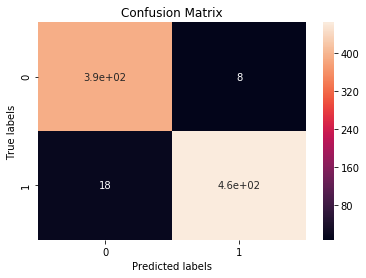

In [83]:
#предсказание
expected = train_target
predicted = eclf3.predict(normalized_train_dataset)

#Отрисовка confusion_matrix
cm = metrics.confusion_matrix(expected, predicted)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')
    
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

f1ScoreWeighted=f1_score(train_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(train_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)

f1ScoreBinary=f1_score(train_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

buff_score=eclf3.score(normalized_train_dataset, train_target)
print('Точноть',buff_score)

# Взвешенное голосование

RDF knn lg

0.8990929705215419
0.9421768707482994
0.9478458049886621 

0.7171717171717171
0.7373737373737373
0.7676767676767676 

[[37  8]
 [15 39]]
Специфичность 0.8222222222222222
Чувствительность 0.7222222222222222
--------------
f1ScoreWeighted= 0.7680087596388505
f1ScoreMacro= 0.7675819128304584
f1ScoreBinary= 0.7722772277227723
Точноть 0.7676767676767676


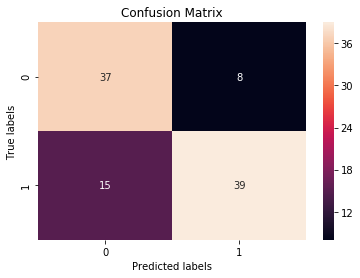

In [84]:
eclf1 = VotingClassifier(estimators=[('RDF',RDF_grid_model),('knn', knnModel), 
                                     ('lg', lgModel),], 
                                     voting='hard')
eclf1 = eclf1.fit(normalized_train_dataset, train_target)

eclf2 = VotingClassifier(estimators=[('RDF',RDF_grid_model),('knn', knnModel),
                                     ('lg', lgModel)],
                                     voting='soft')
eclf2 = eclf2.fit(normalized_train_dataset, train_target)

eclf3 = VotingClassifier(estimators=[('RDF',RDF_grid_model),('knn', knnModel), 
                                     ('lg', lgModel),],
                                    voting='soft', flatten_transform=True)
eclf3 = eclf3.fit(normalized_train_dataset, train_target)

print(eclf1.score( normalized_train_dataset, train_target))
print(eclf2.score( normalized_train_dataset, train_target))
print(eclf3.score( normalized_train_dataset, train_target),'\n')

print(eclf1.score( normalized_test_dataset, test_target))
print(eclf2.score( normalized_test_dataset, test_target))
print(eclf3.score( normalized_test_dataset, test_target),'\n')

# Score.append(max(eclf1.score( normalized_test_dataset, test_target),
#                            eclf2.score( normalized_test_dataset, test_target),
#                            eclf3.score( normalized_test_dataset, test_target)))
expected = test_target
predicted_VotingClassifier3 = eclf3.predict(normalized_test_dataset)

#---------------------------------------------------------------------
#Отрисовка confusion_matrix
cm = metrics.confusion_matrix(expected, predicted_VotingClassifier3)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['О', 'К']); 
# ax.yaxis.set_ticklabels(['О', 'К']);
#--------------------------------------------------------------------
#Результаты
f1ScoreWeighted_VotingClassifier3=f1_score(test_target, predicted_VotingClassifier3, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted_VotingClassifier3)

f1ScoreMacro_VotingClassifier3=f1_score(test_target, predicted_VotingClassifier3, average='macro')
print("f1ScoreMacro=",f1ScoreMacro_VotingClassifier3)
      
f1ScoreBinary_VotingClassifier3=f1_score(test_target, predicted_VotingClassifier3, average='binary')
print("f1ScoreBinary=",f1ScoreBinary_VotingClassifier3)

buff_score=eclf3.score(normalized_test_dataset, test_target)
Score.append(buff_score)
print('Точноть',buff_score)
NameModel.append("VotingClassifier3")
# save,name=saveModel(Score[len(Score)-1],path,NameModel[len(NameModel)-1])
# if save==True:
#     with open(name, 'wb') as fid:
#         pickle.dump(eclf3, fid)

# Обучающая выборка

[[386  14]
 [ 32 450]]
Специфичность 0.965
Чувствительность 0.9336099585062241
--------------
f1ScoreWeighted= 0.9479234470908517
f1ScoreMacro= 0.9475697441808775
f1ScoreBinary= 0.9513742071881607
Точноть 0.9478458049886621


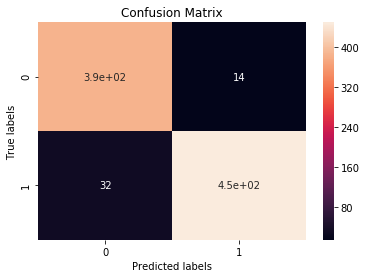

In [85]:
#предсказание
expected = train_target
predicted = eclf3.predict(normalized_train_dataset)

#Отрисовка confusion_matrix
cm = metrics.confusion_matrix(expected, predicted)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')
    
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

f1ScoreWeighted=f1_score(train_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(train_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)

f1ScoreBinary=f1_score(train_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

buff_score=eclf3.score(normalized_train_dataset, train_target)
print('Точноть',buff_score)

No handles with labels found to put in legend.


[0.696969696969697, 0.6262626262626263, 0.7676767676767676, 0.7070707070707071, 0.6666666666666666, 0.5252525252525253, 0.696969696969697, 0.7575757575757576, 0.7676767676767676]
['nuSVC', 'cartModel', 'lgModel', 'knnModel', 'RDF', 'nbModel', 'VotingClassifier1', 'VotingClassifier2', 'VotingClassifier3']


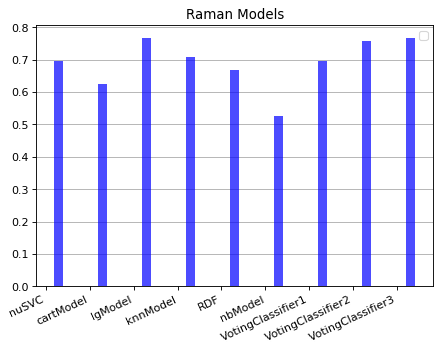

In [86]:
print(Score)
print(NameModel)
# Score=[0.6649484536082475, 0.6925064599483205, 0.7614213197969544, 0.6577181208053692, 0.6909090909090908, 0.555979381443296]
# NameModel=['SVC', 'CART', 'LR', 'KNN','RDF','NB']
# Score=[0.6649484536082475, 0.6925064599483205, 0.7614213197969544, 0.6577181208053692, 0.6909090909090908, 0.28865979381443296, 0.7520000000000001, 0.7365269461077845, 0.8010471204188482, 0.6909090909090908, 0.7152941176470589, 0.702127659574468, 0.7136150234741784]
# NameModel=['nuSVC', 'cartModel', 'lgModel', 'knnModel', 'RDF', 'nbModel', 'VotingClassifier1', 'VotingClassifier2', 'VotingClassifier3', 'stacker_Ridge', 'stacker Log Reg', 'stackerknnModel', 'stacker_RDF_grid']

from pandas import date_range,Series,DataFrame,read_csv, qcut
from numpy.random import rand

#df2 = pd.DataFrame(a, columns=['NameModel'])
#df2.plot(kind='bar');

dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )
mpl.rcParams.update({'font.size': 10})
plt.title('Raman Models')
ax = plt.axes()
ax.yaxis.grid(True, zorder = 1)
xs = range(len(NameModel))
plt.bar([x + 0.3 for x in xs], Score,
        width = 0.2, color = 'blue', alpha = 0.7,
        zorder = 2)
plt.xticks(xs,NameModel)

fig.autofmt_xdate(rotation = 25)

plt.legend(loc='upper right')
fig.savefig('Score.png')

[73.33333333333333, 94.75, 44.44444444444444, 80.5, 77.77777777777779, 89.5, 75.55555555555556, 82.5, 51.11111111111111, 82.5, 95.55555555555556, 95.25, 86.66666666666667, 98.75, 86.66666666666667, 98.0, 82.22222222222221, 96.5]


ValueError: shape mismatch: objects cannot be broadcast to a single shape

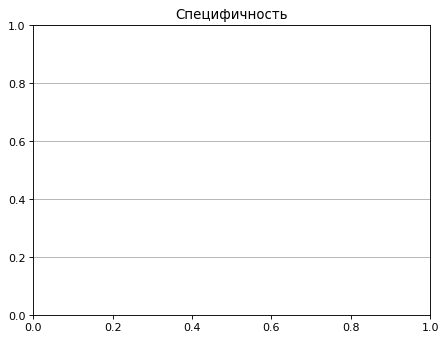

In [87]:
spec=[i * 100 for i in spec]
print(spec)
from pandas import date_range,Series,DataFrame,read_csv, qcut
from numpy.random import rand

#df2 = pd.DataFrame(a, columns=['NameModel'])
#df2.plot(kind='bar');

dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )
mpl.rcParams.update({'font.size': 10})
plt.title('Специфичность')
ax = plt.axes()
ax.yaxis.grid(True, zorder = 1)
xs = range(len(NameModel))
plt.bar([x + 0.3 for x in xs], spec,
        width = 0.2, color = 'blue', alpha = 0.7,
        zorder = 2)
plt.xticks(xs,NameModel)

fig.autofmt_xdate(rotation = 25)

plt.legend(loc='upper right')
fig.savefig('spec.png')

In [ ]:
ch=[i * 100 for i in ch]
print(ch)
from pandas import date_range,Series,DataFrame,read_csv, qcut
from numpy.random import rand

#df2 = pd.DataFrame(a, columns=['NameModel'])
#df2.plot(kind='bar');

dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )
mpl.rcParams.update({'font.size': 10})
plt.title('Чувствительность')
ax = plt.axes()
ax.yaxis.grid(True, zorder = 1)
xs = range(len(NameModel))
plt.bar([x + 0.3 for x in xs], ch,
        width = 0.2, color = 'blue', alpha = 0.7,
        zorder = 2)
plt.xticks(xs,NameModel)

fig.autofmt_xdate(rotation = 25)

plt.legend(loc='upper right')
fig.savefig('ch.png')